In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import mlflow
from mlflow import MlflowClient
import os
import pickle

In [4]:
df = pd.read_csv('/home/kaustubh/mlops_zoomcamp/final_project/project_1/data/extended_crab_age_pred.csv')

In [13]:
df.shape

(199999, 9)

In [14]:
df.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,M,1.5750,1.2250,0.3750,31.226974,12.303683,6.321938,9.638830,10.0
1,I,1.2375,1.0000,0.3750,21.885814,7.654365,3.798833,7.654365,19.0
2,F,1.4500,1.1625,0.4125,28.250277,11.127179,7.016501,7.257472,11.0
3,I,1.3500,1.0250,0.3750,21.588144,9.738053,4.110678,6.378637,9.0
4,I,1.1375,0.8750,0.2875,14.968536,5.953395,2.962523,3.713785,8.0


In [15]:
df.Sex.unique()

array(['M', 'I', 'F'], dtype=object)

In [26]:
df.describe()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000
mean,1.312453,1.020324,0.346029,23.123550,9.989419,4.993205,6.634262,9.950645
std,0.289827,0.238718,0.091178,12.597752,5.604314,2.785698,3.556713,3.217069
min,0.000000,0.000000,0.000000,0.028349,0.014175,0.014175,0.042524,1.000000
25%,1.150000,0.875000,0.287500,13.154168,5.669900,2.792426,3.827183,8.000000
50%,1.375000,1.075000,0.362500,23.515910,9.851451,4.890289,6.803880,10.000000
75%,1.525000,1.200000,0.412500,32.063285,13.933779,6.959802,9.029316,11.000000
max,7.583491,2.250000,2.825000,80.101512,45.274152,26.124064,37.038622,29.000000


Text(0.5, 1.0, 'Train')

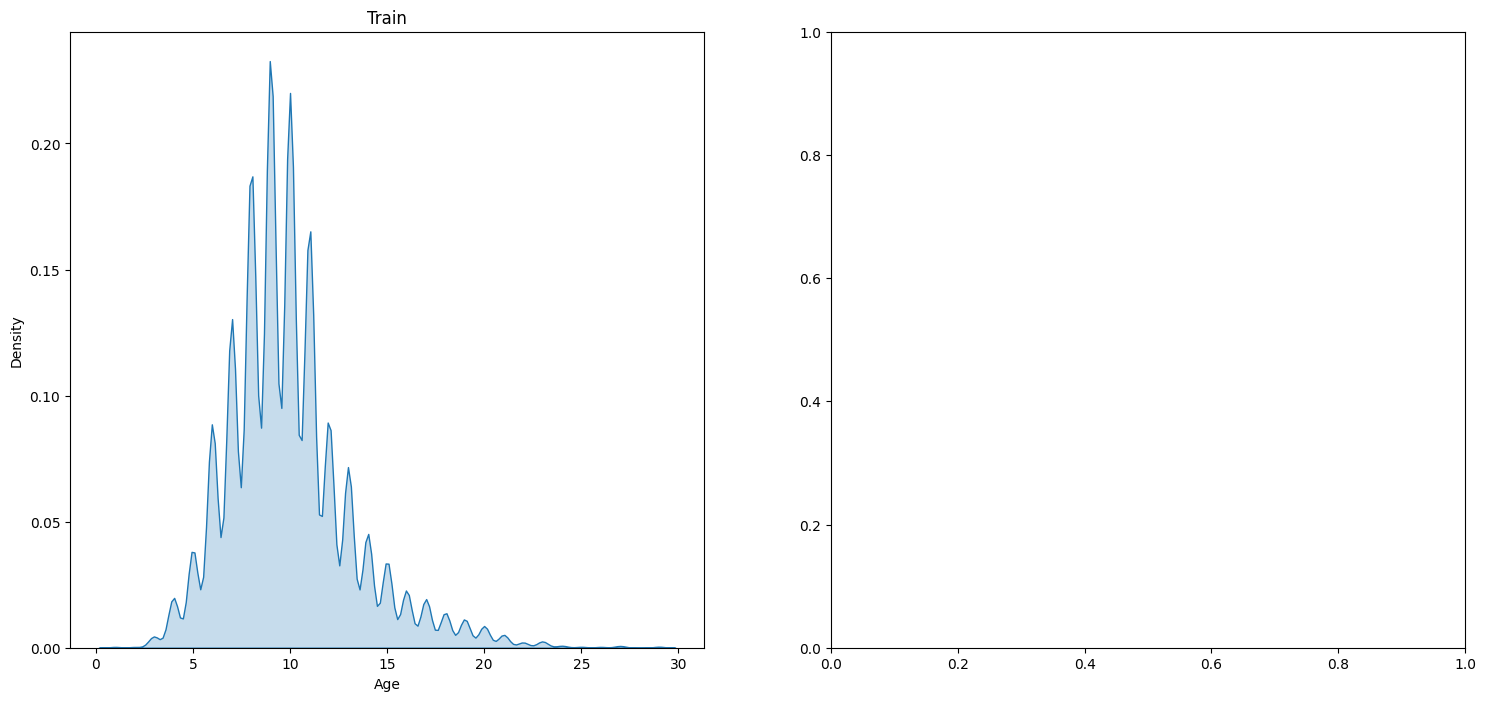

In [25]:
fig,axes=plt.subplots(1,2,figsize=(18,8))
sns.kdeplot(ax=axes[0],data=df,x='Age',fill=True).set_title('Train')

<Axes: >

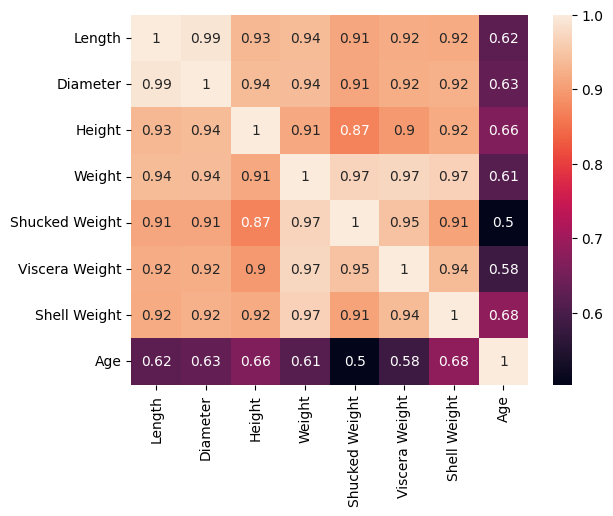

In [28]:
sns.heatmap(df.corr(numeric_only=True),annot=True)

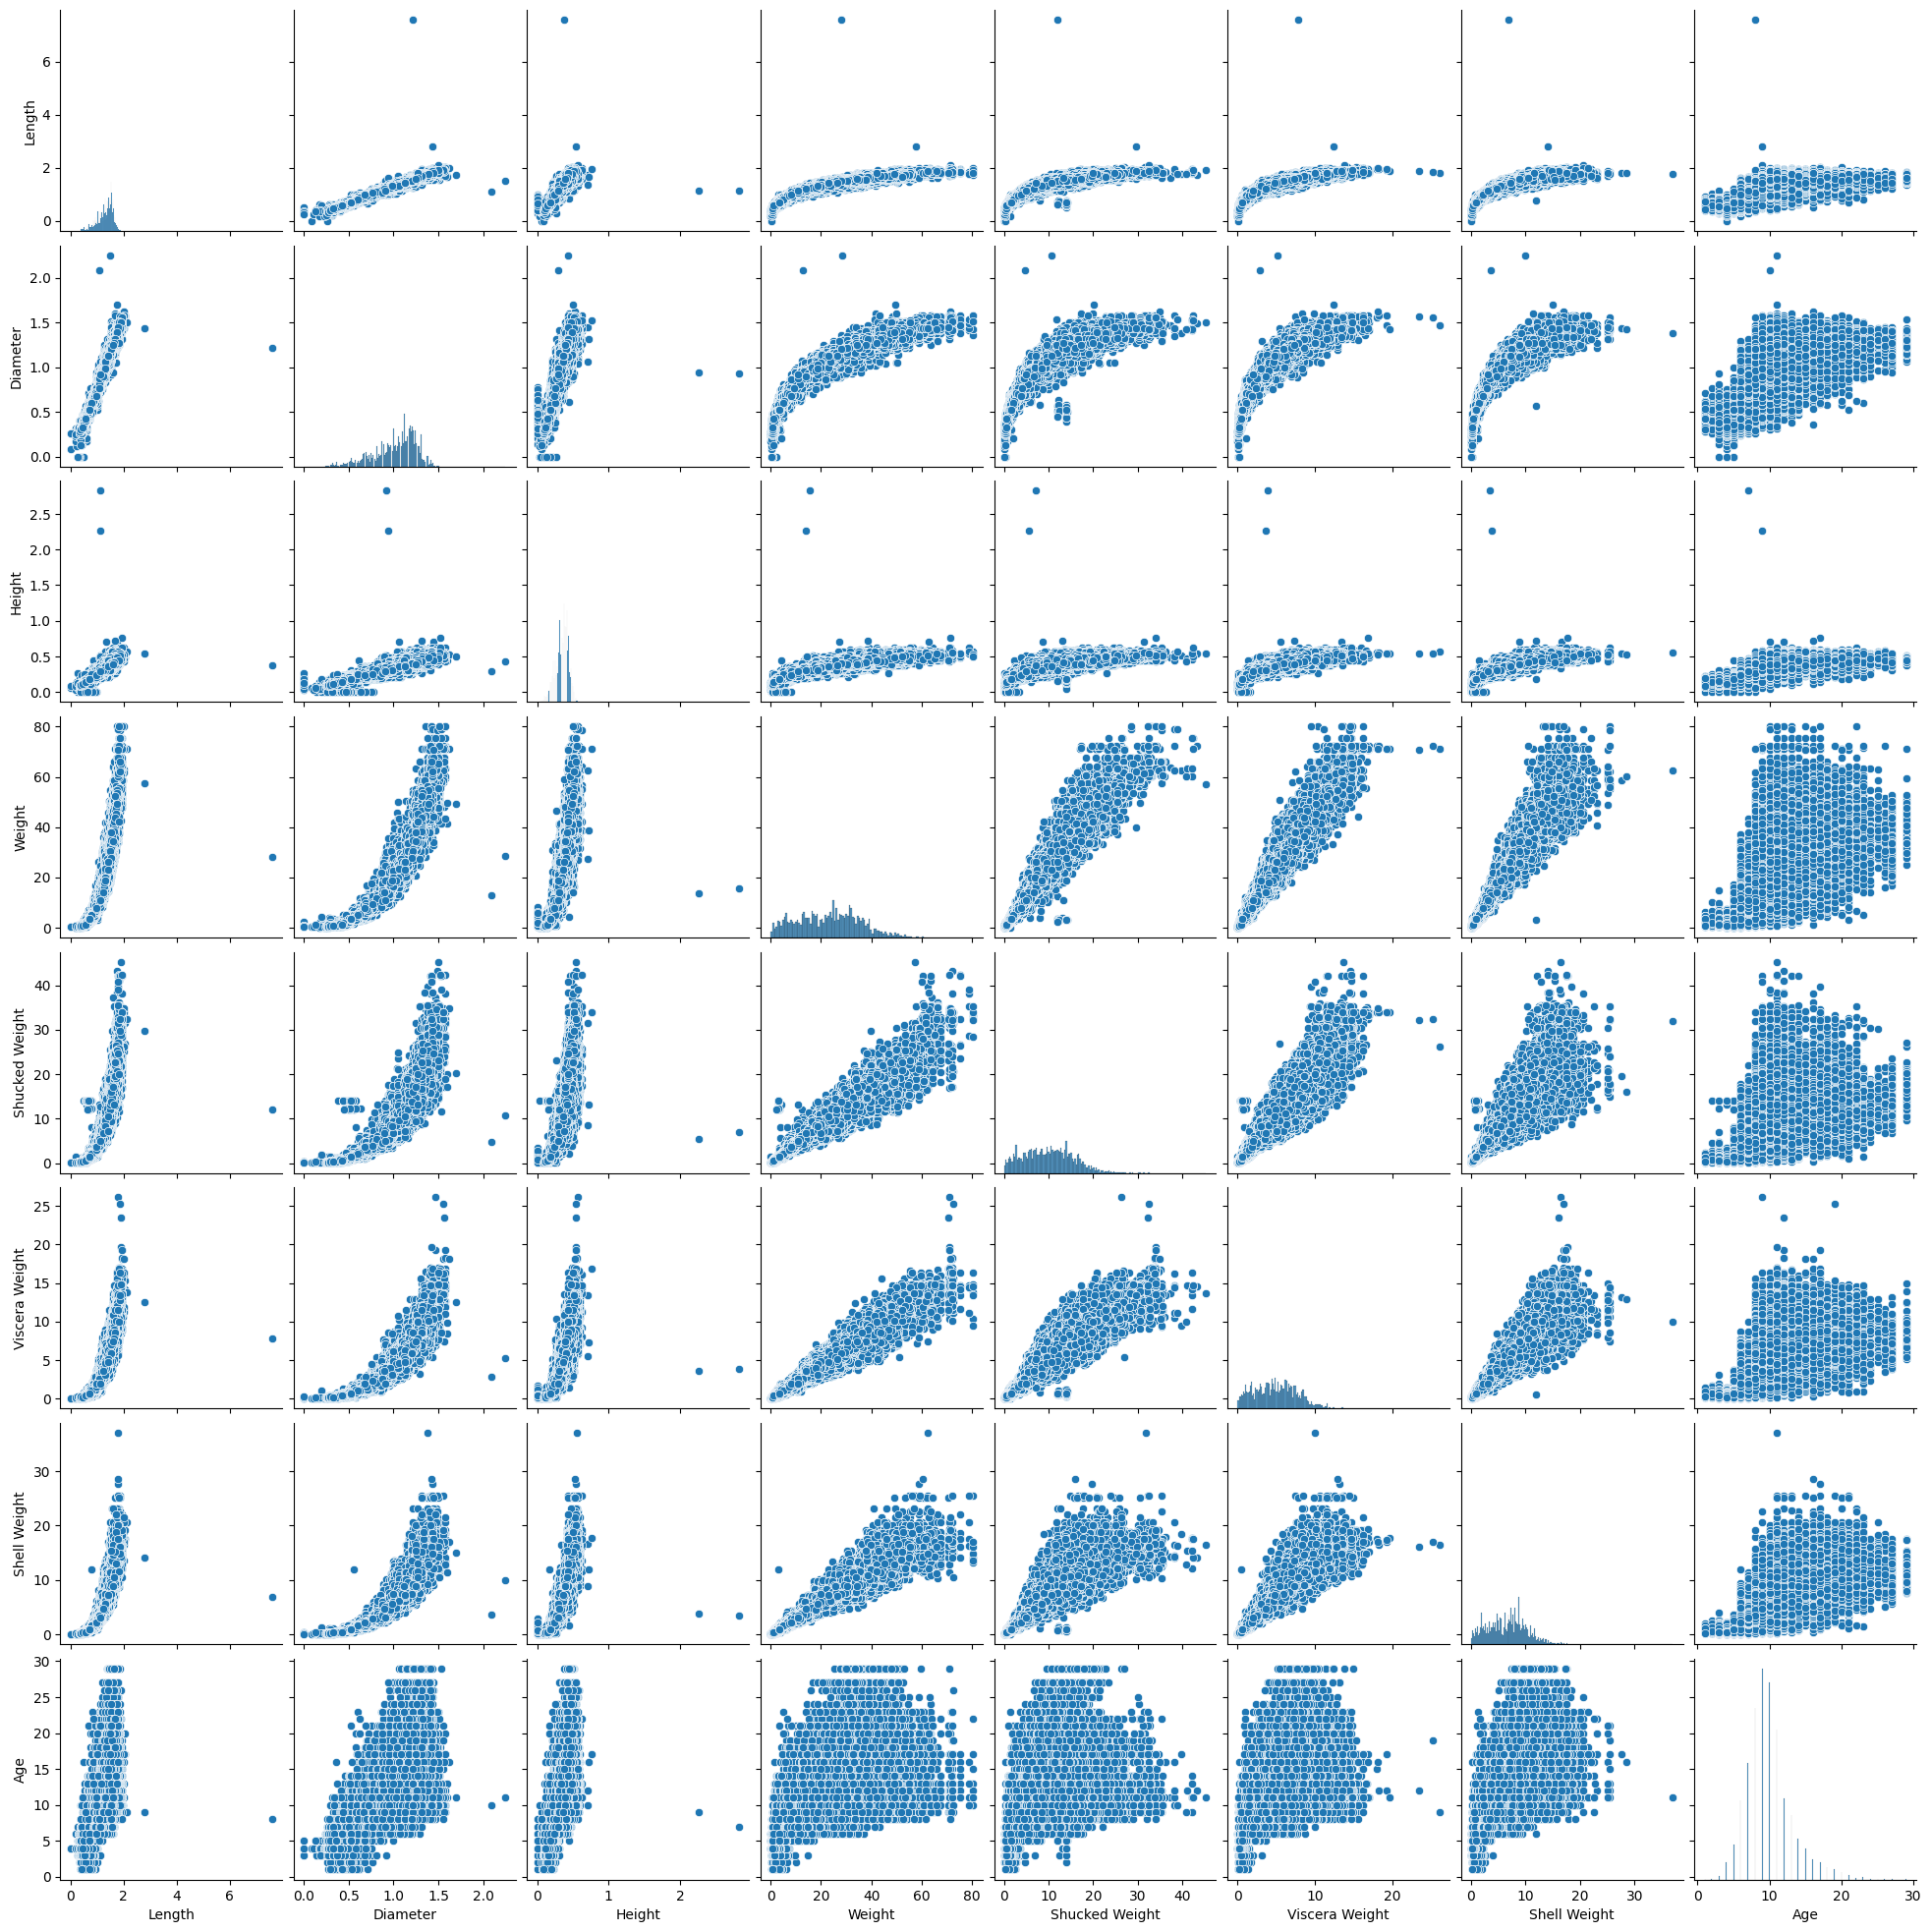

In [29]:
sns.pairplot(df)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199999 entries, 0 to 199998
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Sex             199999 non-null  object 
 1   Length          199999 non-null  float64
 2   Diameter        199999 non-null  float64
 3   Height          199999 non-null  float64
 4   Weight          199999 non-null  float64
 5   Shucked Weight  199999 non-null  float64
 6   Viscera Weight  199999 non-null  float64
 7   Shell Weight    199999 non-null  float64
 8   Age             199999 non-null  float64
dtypes: float64(8), object(1)
memory usage: 13.7+ MB


In [8]:
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_columns

['Sex',
 'Length',
 'Diameter',
 'Height',
 'Weight',
 'Shucked Weight',
 'Viscera Weight',
 'Shell Weight',
 'Age']

In [10]:
scaler = StandardScaler()

# Fit scaler to training data and transform
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])


In [11]:
df

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,1.158890,0.905880,0.857399,0.317744,0.643245,0.412944,0.476985,0.844762,0.015342
1,-0.068573,-0.258613,-0.085139,0.317744,-0.098251,-0.416654,-0.428753,0.286811,2.812926
2,-1.296036,0.474586,0.595583,0.729029,0.406957,0.203015,0.726317,0.175221,0.326184
3,-0.068573,0.129551,0.019587,0.317744,-0.121880,-0.044852,-0.316808,-0.071871,-0.295501
4,-0.068573,-0.603648,-0.608771,-0.641921,-0.647340,-0.720166,-0.728969,-0.821119,-0.606344
...,...,...,...,...,...,...,...,...,...
199994,-1.296036,1.725337,1.066851,1.003219,1.509637,1.786334,1.789796,1.398727,0.326184
199995,-1.296036,-1.121200,-1.446582,-1.190301,-1.202056,-1.114731,-1.105512,-1.227626,-1.228029
199996,1.158890,-0.646777,-0.451681,-0.641921,-0.971393,-0.907331,-1.080070,-0.988504,-0.917186
199997,-0.068573,1.078397,1.066851,0.729029,0.854780,0.572288,1.031622,1.083884,0.326184


In [6]:
le = LabelEncoder()

In [7]:
df['Sex'] = le.fit_transform(df['Sex'])
df

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,2,1.5750,1.2250,0.3750,31.226974,12.303683,6.321938,9.638830,10.0
1,1,1.2375,1.0000,0.3750,21.885814,7.654365,3.798833,7.654365,19.0
2,0,1.4500,1.1625,0.4125,28.250277,11.127179,7.016501,7.257472,11.0
3,1,1.3500,1.0250,0.3750,21.588144,9.738053,4.110678,6.378637,9.0
4,1,1.1375,0.8750,0.2875,14.968536,5.953395,2.962523,3.713785,8.0
...,...,...,...,...,...,...,...,...,...
199994,0,1.8125,1.2750,0.4375,42.141532,20.000572,9.979024,11.609120,11.0
199995,0,0.9875,0.6750,0.2375,7.980384,3.742134,1.913591,2.267960,6.0
199996,2,1.1250,0.9125,0.2875,10.886208,4.904464,1.984465,3.118445,7.0
199997,1,1.6250,1.2750,0.4125,33.891827,13.196692,7.866986,10.489315,11.0


In [34]:
df["Sex"].value_counts()

Sex
2    72270
1    66632
0    61097
Name: count, dtype: int64

In [35]:
X=df.drop(columns=["Age"])
Y=df["Age"]

In [37]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [38]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, Y_train)

# Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, Y_train)

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, Y_train)


RandomForestRegressor(random_state=42)

In [41]:
# Linear Regression
Y_pred_lr = lr.predict(X_test)
mse_lr = mean_squared_error(Y_test, Y_pred_lr)
r2_lr = r2_score(Y_test, Y_pred_lr)
print(f"Linear Regression MSE: {mse_lr}, R^2 Score: {r2_lr}")

# Decision Tree Regressor
Y_pred_dt = dt.predict(X_test)
mse_dt = mean_squared_error(Y_test, Y_pred_dt)
r2_dt = r2_score(Y_test, Y_pred_dt)
print(f"Decision Tree Regressor MSE: {mse_dt}, R^2 Score: {r2_dt}")

# Random Forest Regressor
Y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(Y_test, Y_pred_rf)
r2_rf = r2_score(Y_test, Y_pred_rf)
print(f"Random Forest Regressor MSE: {mse_rf}, R^2 Score: {r2_rf}")


Linear Regression MSE: 4.310807559765532, R^2 Score: 0.5818755930011899
Decision Tree Regressor MSE: 7.959782880357535, R^2 Score: 0.22794523983116577
Random Forest Regressor MSE: 4.031276052426537, R^2 Score: 0.6089885977278398


In [46]:
os.environ["MLFLOW_TRACKING_URI"]="sqlite:////home/kaustubh/mlops_zoomcamp/final_project/project_1/mlflow.db"
os.environ["MLFLOW_EXPERIMENT_NAME"]="training-pipeline"

In [47]:
MLFLOW_TRACKING_URI = os.getenv("MLFLOW_EXPERIMENT_URI", "sqlite:////home/kaustubh/mlops_zoomcamp/final_project/project_1/mlflow.db")
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)
experiment_name = os.getenv("EXPERIMENT_NAME", "training-pipeline")
mlflow.set_experiment(experiment_name)

2024/07/21 10:44:48 INFO mlflow.tracking.fluent: Experiment with name 'training-pipeline' does not exist. Creating a new experiment.


<Experiment: artifact_location='/home/kaustubh/mlops_zoomcamp/final_project/project_1/notebooks/mlruns/1', creation_time=1721538888502, experiment_id='1', last_update_time=1721538888502, lifecycle_stage='active', name='training-pipeline', tags={}>

In [49]:
with mlflow.start_run():
    
    mlflow.sklearn.autolog()
    mlflow.set_tag("developer", "kaustubh")

    # mlflow.log_param("train-data-path", "/home/kaustubh/mlops_zoomcamp/Mlops-ZoomCamp/data/green_tripdata_2023-01.parquet")
    # mlflow.log_param("valid-data-path", "/home/kaustubh/mlops_zoomcamp/Mlops-ZoomCamp/data/green_tripdata_2023-02.parquet")
  
    
    alpha=0.0001
    lr = Lasso(alpha=alpha)
    lr.fit(X_train, Y_train)

    y_pred = lr.predict(X_test)
    rmse = mean_squared_error(Y_test, y_pred, squared=False)
    mlflow.log_metric("rmse",rmse)
    

2024/07/21 10:48:21 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2024/07/21 10:48:24 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/kaustubh/.local/share/virtualenvs/project_1-4NMMvVlY/lib/python3.12/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers Wit

In [52]:
with mlflow.start_run():
    
    mlflow.set_tag("developer", "kaustubh")
    mlflow.set_tag("model", "lin_reg")
    
    
    lr = LinearRegression()
    lr.fit(X_train, Y_train)

    y_pred = lr.predict(X_test)

    rmse = mean_squared_error(Y_test, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    
    with open('models/lin_reg.bin', 'wb') as f_out:
        pickle.dump((le, lr), f_out)

    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")

2024/07/21 18:36:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/kaustubh/.local/share/virtualenvs/project_1-4NMMvVlY/lib/python3.12/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/07/21 18:36:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/kaus